# Chromatin Loop Filtering in ChIA-PET Data (GM12878)

## Environment Setup (Optional)

### Required Software and Packages

#### Python Packages (installed via `pip` or `conda`):
- `pandas`
- `numpy`
- `pyranges`
- `matplotlib`
- `matplotlib-venn`
- `gzip`
- `seaborn` *(optional, for extended plotting)*

A conda environment can be created as follows:

```bash
conda create -n genomics_env python=3.10
conda activate genomics_env
pip install pandas numpy pyranges matplotlib matplotlib-venn
```

### MEME Suite Installation (for CTCF Motif Scanning)

To perform motif scanning using FIMO, the MEME Suite must be installed.

Install MEME Suite via conda:

```bash
conda install -c bioconda meme
```

### Genome Reference Preparation
The reference genome must match the genome assembly used in the ChIA-PET and ChIP-seq experiments.
In this project, the data is based on GRCh38 / hg38.

```bash
wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
gunzip hg38.fa.gz
```
### CTCF Motif (PWM) Preparation

The CTCF motif used in this analysis corresponds to the JASPAR motif MA0139.1.

Download the motif from JASPAR:
Go to: https://jaspar.elixir.no/matrix/MA0139.1/

Under the "Download" section, click on the MEME format.

Save the file as: CTCF_motif_MEME.txt

### Scanning Genome with FIMO
Use the following command to scan the genome for CTCF motifs:

```bash
fimo --oc fimo_output/ CTCF_motif_MEME.txt hg38.fa
```

### Convert FIMO Output to BED Format
Extract chromosomal coordinates from fimo.tsv:

```bash
cd fimo_output
awk 'NR > 1 {print $3 "\t" $4 "\t" $5}' fimo.tsv > CTCF_motif.bed
```
Sort and compress the file for downstream analysis:
```bash
sort -k1,1 -k2,2n CTCF_motif.bed > CTCF_motif.sorted.bed
bgzip -f CTCF_motif.sorted.bed
tabix -p bed CTCF_motif.sorted.bed.gz
```


## 1. Brief Project Description

This project focuses on the filtering of chromatin loops derived from a **ChIA-PET** experiment conducted on the GM12878 cell line. The goal is to identify loops that are supported by the presence of **CTCF** and **Rad21** (a cohesin complex subunit) at their anchors.

For each protein:
- Loops containing **at least one anchor** overlapping a ChIP-seq peak are selected.
- Loops with **both anchors** overlapping a ChIP-seq peak are also identified.

Next, the overlap between loops supported by CTCF and Rad21 is assessed to determine the extent of their co-occurrence in chromatin loop formation.

---

### Extra Credit: CTCF Motif Analysis

To further validate the functional relevance of CTCF-mediated loops, an additional analysis was performed to detect the presence of **CTCF DNA-binding motifs** at loop anchors.

The following steps were carried out:
1. The **position weight matrix (PWM)** for CTCF was obtained from the [JASPAR database (MA0139.1)](https://jaspar.elixir.no/matrix/MA0139.1/).
2. The **hg38 reference genome** was scanned for motif occurrences using **FIMO**, a tool from the MEME Suite.
3. The output of FIMO was converted into BED format and intersected with loop anchor regions.

Each loop was evaluated to determine whether:
- **At least one anchor** contains a CTCF motif occurrence,
- **Both anchors** contain the motif.

This analysis allows for the identification of loops that are not only bound by CTCF (based on ChIP-seq data), but also exhibit sequence specificity consistent with CTCF binding motifs. The presence of canonical motifs provides stronger evidence for the regulatory role of CTCF in loop formation. The results of this analysis are included in the final statistics and visualizations.

## 2. Data Sources

1. **ChIA-PET loops (GM12878)**
   Downloaded from [4D Nucleome: 4DNES7IB5LY9](https://data.4dnucleome.org/experiment-set-replicates/4DNES7IB5LY9/).
   Example file used: `4DNFIS9CCN6R.bedpe.gz` (long-range chromatin interactions).

2. **CTCF ChIP-seq peaks (GM12878)**
   Obtained from the [ENCODE Project: ENCFF356LIU](https://www.encodeproject.org/files/ENCFF356LIU/).

3. **Rad21 ChIP-seq peaks (GM12878)**
   Obtained from the [ENCODE Project: ENCFF834GOT](https://www.encodeproject.org/files/ENCFF834GOT/).

4. **CTCF Motif (PWM) Data**
   - **Motif Source**: [JASPAR MA0139.1](https://jaspar.elixir.no/matrix/MA0139.1/)
   - **Genome-wide motif occurrences** were identified using **FIMO** (from MEME Suite) on the **hg38** reference genome.
   - The reference genome was downloaded from the [UCSC Genome Browser Downloads page](https://hgdownload.soe.ucsc.edu/downloads.html).
   - Output was converted to a sorted `BED` file, `CTCF_motif.sorted.bed.gz`, for intersection with loop anchors.

---

**File Formats**

- **ChIA-PET (BEDPE)**: Provided as `.bedpe.gz`, typically containing at least six columns:
  \[ `chrom1`, `start1`, `end1`, `chrom2`, `start2`, `end2` \].
- **CTCF / Rad21 ChIP-seq (BED)**: Provided as `.bed.gz` with at least three columns:
  \[ `chrom`, `start`, `end` \].
- **CTCF Motifs (BED)**: Resulting `.bed.gz` file from FIMO, containing columns:
  \[ `chrom`, `start`, `end` \].


## 3. Exploratory Data Analysis

The following code snippet loads the primary data files using Python (`pandas`, `gzip`) and prints basic statistics (record counts, head of each DataFrame). The data files include:

- **ChIA-PET loops** in BEDPE format (`.bedpe.gz`)
- **CTCF peaks** in BED format (`.bed.gz`)
- **Rad21 peaks** in BED format (`.bed.gz`)
- **CTCF motif occurrences** (derived from FIMO), in **sorted** BED format (`.bed.gz`)

> **Note:** Update the file paths (`chia_pet_path`, `ctcf_path`, `rad21_path`, `ctcf_motif_path`) to match the local paths on your system.


In [53]:
import pandas as pd
import gzip

def load_motif_bed(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(
            f, sep='\t', comment='#', header=None,
            names=["chrom", "start", "end"]
        )
    return df

def load_bedpe(file_path):
    with gzip.open(file_path, 'rt') as f:
        columns = ["chrom1", "start1", "end1", "chrom2", "start2", "end2"]
        df = pd.read_csv(f, sep='\t', comment='#', header=None, usecols=range(6), names=columns)
    return df


def load_bed(file_path):
    with gzip.open(file_path, 'rt') as f:
        columns = ["chrom", "start", "end"]
        df = pd.read_csv(f, sep='\t', comment='#', header=None, usecols=range(3), names=columns)
    return df

#Define paths to the data files
chia_pet_path = "/home/kubog/genomics_data/4DNFIS9CCN6R.bedpe.gz"
ctcf_path = "/home/kubog/genomics_data/ENCFF356LIU.bed.gz"
rad21_path = "/home/kubog/genomics_data/ENCFF834GOT.bed.gz"
ctcf_motif_path = "/home/kubog/Genomics/GenomicsProject1/fimo_output/CTCF_motif.sorted.bed.gz"

chia_pet_df = load_bedpe(chia_pet_path)
ctcf_df = load_bed(ctcf_path)
rad21_df = load_bed(rad21_path)
ctcf_motif_df = load_motif_bed(ctcf_motif_path)

print("### ChIA-PET Loops (HEAD) ###")
print(chia_pet_df.head())
print(f"Number of loops (ChIA-PET): {len(chia_pet_df)}\n")

print("### CTCF Peaks (HEAD) ###")
print(ctcf_df.head())
print(f"Number of peaks (CTCF): {len(ctcf_df)}\n")

print("### Rad21 Peaks (HEAD) ###")
print(rad21_df.head())
print(f"Number of peaks (Rad21): {len(rad21_df)}")

print("### CTCF Motifs (HEAD) ###")
print(ctcf_motif_df.head())
print(f"Number of motifs (CTCF): {len(ctcf_motif_df)}")


### ChIA-PET Loops (HEAD) ###
  chrom1  start1   end1 chrom2    start2      end2
0  chr10   49043  49694  chr10   1596907   1597444
1  chr10   49291  49814  chr10  71061105  71061664
2  chr10   50096  50747  chr10  19437275  19437902
3  chr10   52377  52917  chr10     78536     79151
4  chr10   52428  53079  chr10    806777    807334
Number of loops (ChIA-PET): 5815083

### CTCF Peaks (HEAD) ###
   chrom     start       end
0   chr3  39812740  39813090
1   chr2  96508234  96508584
2  chr20    577635    577985
3  chr14  23094608  23094958
4   chr3  24683997  24684347
Number of peaks (CTCF): 40949

### Rad21 Peaks (HEAD) ###
   chrom      start        end
0   chrX   10119439   10119802
1   chr4  147866870  147867089
2  chr20   34312736   34312962
3  chr10  102009907  102010123
4   chr3   39288401   39288604
Number of peaks (Rad21): 34623
### CTCF Motifs (HEAD) ###
  chrom   start     end
0  chr1   11223   11241
1  chr1   11281   11299
2  chr1   24782   24800
3  chr1   91420   91438
4  ch

## 4. Anchor Extraction and Peak Overlap Detection

This section defines utility functions that perform essential preprocessing steps for loop annotation. These include extracting anchor regions from ChIA-PET loop data, converting genomic regions to `PyRanges` format, and finding overlaps between loop anchors and genomic features such as ChIP-seq peaks or motif occurrences.

### 4.1. Extracting Anchors from ChIA-PET Loops

The function `chia_pet_anchors_to_pyranges()` extracts either the first or second anchor from each loop and returns it as a `PyRanges` object. Each anchor is associated with a unique `loop_id` corresponding to its row index in the input DataFrame.

### 4.2. Converting BED-formatted Data to PyRanges
The function bed_df_to_pyranges() converts a standard 3-column BED DataFrame into the format required by PyRanges by renaming columns accordingly.

### 4.3. Detecting Overlaps Between Loop Anchors and Peaks
The function find_loops_with_peak() performs an intersection between ChIA-PET anchors and a given genomic feature (e.g., CTCF peaks, Rad21 peaks, or motif regions). It returns a set of loop_ids for which at least one anchor overlaps the feature of interest.

In [55]:
import pyranges as pr
import pandas as pd

def chia_pet_anchors_to_pyranges(chia_pet_df, anchor=1):
    """
    For a DataFrame with columns [chrom1, start1, end1, chrom2, start2, end2],
    extract one anchor (anchor=1 or anchor=2) and return a PyRanges object
    with columns [Chromosome, Start, End, loop_id].
    """
    anchor_data = []
    for loop_id, row in chia_pet_df.iterrows():
        if anchor == 1:
            chrom, start, end = row["chrom1"], row["start1"], row["end1"]
        else:
            chrom, start, end = row["chrom2"], row["start2"], row["end2"]
        anchor_data.append([chrom, start, end, loop_id])

    anchor_df = pd.DataFrame(anchor_data, columns=["Chromosome", "Start", "End", "loop_id"])
    return pr.PyRanges(anchor_df)

def bed_df_to_pyranges(bed_df):
    """
    For a DataFrame with columns [chrom, start, end],
    return a PyRanges object with [Chromosome, Start, End].
    """
    pr_df = bed_df.rename(columns={
        "chrom": "Chromosome",
        "start": "Start",
        "end":   "End"
    })
    return pr.PyRanges(pr_df)

def find_loops_with_peak(chia_pet_pyr, peak_pyr):
    """
    Intersect (join) the ChIA-PET anchors PyRanges with the peak PyRanges
    and return a set of loop_ids that have at least one peak in an anchor.
    """
    overlap_result = chia_pet_pyr.join(peak_pyr)
    loop_ids = set(overlap_result.df["loop_id"])
    return loop_ids


## 5. Annotation and Visualization Functions

This section defines functions responsible for annotating ChIA-PET loops based on overlap with ChIP-seq peaks (CTCF and Rad21), and generating visual summaries of the results.

---

### 5.1. Loop Annotation Function

The `annotate_and_save_results()` function labels each loop with boolean flags indicating whether:
- At least one anchor contains a CTCF peak,
- Both anchors contain CTCF peaks,
- At least one anchor contains a Rad21 peak,
- Both anchors contain Rad21 peaks.

The updated DataFrame is saved to disk as a `.csv` file.

### 5.2. Basic Bar Plot of Loop Categories
The plot_basic_counts() function visualizes the number of loops falling into four main categories:
- CTCF at ≥1 anchor,
- CTCF at both anchors,
- Rad21 at ≥1 anchor,
- Rad21 at both anchors.

### 5.3. Venn Diagram of CTCF and Rad21 Loops
The plot_overlap_venn() function generates a Venn diagram comparing the sets of loops that have at least one anchor overlapping with:
- CTCF ChIP-seq peaks,
- Rad21 ChIP-seq peaks.

### 5.4. Stacked Bar Plot: Anchors per Loop
The plot_stacked_anchor_counts() function shows the number of loops with:
- 0, 1, or 2 anchors overlapping a peak, for both CTCF and Rad21 in stacked format.

### 5.5. Summary of Overlapping Loop Sets
The plot_protein_overlap_summary() function compares how many loops have:
- Only CTCF overlap,
- Only Rad21 overlap,
- Both (CTCF and Rad21) at one or both anchors.

### 5.6. Extra Credit – CTCF Motif Plot
The plot_ctcf_motif_counts() function shows how many loops contain the CTCF motif (as found using FIMO) in:
- One anchor,
- Both anchors.

In [56]:
import matplotlib.pyplot as plt

def annotate_and_save_results(chia_pet_df, ctcf_anchor1, ctcf_anchor2,
                              rad21_anchor1, rad21_anchor2, out_file):
    # Sets of loops with ≥1 anchors (CTCF or Rad21) or 2 anchors
    ctcf_1anchor_set = ctcf_anchor1.union(ctcf_anchor2)
    ctcf_2anchors_set = ctcf_anchor1.intersection(ctcf_anchor2)

    rad21_1anchor_set = rad21_anchor1.union(rad21_anchor2)
    rad21_2anchors_set = rad21_anchor1.intersection(rad21_anchor2)

    chia_pet_df['CTCF_1anchor'] = chia_pet_df.index.map(lambda i: i in ctcf_1anchor_set)
    chia_pet_df['CTCF_2anchors'] = chia_pet_df.index.map(lambda i: i in ctcf_2anchors_set)
    chia_pet_df['Rad21_1anchor'] = chia_pet_df.index.map(lambda i: i in rad21_1anchor_set)
    chia_pet_df['Rad21_2anchors'] = chia_pet_df.index.map(lambda i: i in rad21_2anchors_set)

    chia_pet_df.to_csv(out_file, index=False)
    print(f"[INFO] Results with annotations saved to: {out_file}")

def plot_basic_counts(ctcf_1anchor, ctcf_2anchors, rad21_1anchor, rad21_2anchors, out_plot):
    labels = [
        "CTCF ≥1 anchor",
        "CTCF 2 anchors",
        "Rad21 ≥1 anchor",
        "Rad21 2 anchors"
    ]
    sizes = [
        len(ctcf_1anchor),
        len(ctcf_2anchors),
        len(rad21_1anchor),
        len(rad21_2anchors)
    ]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, sizes)
    plt.title("Loop Count in Different Categories")
    plt.ylabel("Number of Loops")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_plot)
    plt.show()
    print(f"[INFO] Bar plot saved to: {out_plot}")

from matplotlib_venn import venn2

def plot_overlap_venn(ctcf_1anchor, rad21_1anchor, out_file):
    set_ctcf = set(ctcf_1anchor)
    set_rad21 = set(rad21_1anchor)

    plt.figure(figsize=(6, 6))
    venn2([set_ctcf, set_rad21], set_labels=("CTCF ≥1 anchor", "Rad21 ≥1 anchor"))
    plt.title("Loops with ≥1 Anchor Overlap")
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] Venn diagram saved to: {out_file}")

def plot_stacked_anchor_counts(chia_df, out_file):
    counts = {
        "CTCF": [0, 0, 0],
        "Rad21": [0, 0, 0]
    }

    for _, row in chia_df.iterrows():
        ctcf_count = int(row["CTCF_1anchor"]) + int(row["CTCF_2anchors"])
        rad21_count = int(row["Rad21_1anchor"]) + int(row["Rad21_2anchors"])
        counts["CTCF"][ctcf_count] += 1
        counts["Rad21"][rad21_count] += 1

    labels = ["0 anchors", "1 anchor", "2 anchors"]
    x = range(len(labels))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, counts["CTCF"], label="CTCF")
    ax.bar(x, counts["Rad21"], bottom=counts["CTCF"], label="Rad21")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Number of Loops")
    ax.set_title("Anchors per Loop with Protein Overlap")
    ax.legend()
    plt.tight_layout()
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] Stacked bar chart saved to: {out_file}")

def plot_protein_overlap_summary(ctcf_1anchor, ctcf_2anchors, rad21_1anchor, rad21_2anchors,
                                 overlap_1anchor, overlap_2anchors, out_file):
    labels = [
        "CTCF ≥1 anchor only",
        "Rad21 ≥1 anchor only",
        "CTCF & Rad21 ≥1 anchor",
        "CTCF 2 anchors only",
        "Rad21 2 anchors only",
        "CTCF & Rad21 2 anchors"
    ]

    ctcf_1_only = len(ctcf_1anchor - rad21_1anchor)
    rad21_1_only = len(rad21_1anchor - ctcf_1anchor)
    both_1 = len(overlap_1anchor)

    ctcf_2_only = len(ctcf_2anchors - rad21_2anchors)
    rad21_2_only = len(rad21_2anchors - ctcf_2anchors)
    both_2 = len(overlap_2anchors)

    values = [ctcf_1_only, rad21_1_only, both_1, ctcf_2_only, rad21_2_only, both_2]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'red', 'purple', 'lightblue', 'lightcoral', 'mediumpurple'])
    plt.ylabel("Number of Loops")
    plt.title("Overlap of CTCF and Rad21 in Loop Anchors")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] Overlap comparison plot saved to: {out_file}")

def plot_ctcf_motif_counts(motif_1anchor, motif_2anchors, out_file="ctcf_motif_counts.png"):
    labels = ["CTCF Motif ≥1 anchor", "CTCF Motif 2 anchors"]
    sizes = [len(motif_1anchor), len(motif_2anchors)]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, sizes)
    plt.title("CTCF Motif Overlap with Loop Anchors")
    plt.ylabel("Number of Loops")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] CTCF motif bar plot saved to: {out_file}")



## 6. Integrated Analysis Pipeline – `process_chia_pet()`

The `process_chia_pet()` function serves as the main analysis pipeline for filtering and annotating chromatin loops using ChIA-PET data. It integrates the following components:

- Loads loop and peak datasets (ChIA-PET, CTCF, Rad21, and CTCF motif),
- Converts data into `PyRanges` objects for efficient genomic interval manipulation,
- Identifies loops with at least one or both anchors overlapping ChIP-seq peaks or motifs,
- Computes intersections between CTCF- and Rad21-associated loops,
- Annotates the loop dataset with presence/absence of protein binding and motif matches,
- Saves intermediate and final results,
- Generates plots summarizing loop categories, overlaps, and motif presence.


In [57]:
def process_chia_pet(chia_file, ctcf_file, rad21_file, ctcf_motif_path,
                     start=None, stop=None,
                     out_csv="chia_pet_annotated.csv",
                     out_plot="loop_categories_barplot.png"):
    print("### [INFO] Loading data... ###")
    chia_pet_df = load_bedpe(chia_file)
    ctcf_df = load_bed(ctcf_file)
    rad21_df = load_bed(rad21_file)
    ctcf_motif_df = load_motif_bed(ctcf_motif_path)

    # Optional subset for testing
    if start is not None or stop is not None:
        chia_pet_df = chia_pet_df[start:stop]

    chia_pet_df.reset_index(drop=True, inplace=True)

    print(f"Number of loops for analysis: {len(chia_pet_df)}")

    # Convert to PyRanges
    anchor1_pyr = chia_pet_anchors_to_pyranges(chia_pet_df, anchor=1)
    anchor2_pyr = chia_pet_anchors_to_pyranges(chia_pet_df, anchor=2)
    ctcf_pyr = bed_df_to_pyranges(ctcf_df)
    rad21_pyr = bed_df_to_pyranges(rad21_df)
    ctcf_motif_pyr = bed_df_to_pyranges(ctcf_motif_df)


    # Identify overlapping loops
    ctcf_anchor1 = find_loops_with_peak(anchor1_pyr, ctcf_pyr)
    ctcf_anchor2 = find_loops_with_peak(anchor2_pyr, ctcf_pyr)
    rad21_anchor1 = find_loops_with_peak(anchor1_pyr, rad21_pyr)
    rad21_anchor2 = find_loops_with_peak(anchor2_pyr, rad21_pyr)

    motif_anchor1 = find_loops_with_peak(anchor1_pyr, ctcf_motif_pyr)
    motif_anchor2 = find_loops_with_peak(anchor2_pyr, ctcf_motif_pyr)

    all_loops = set(chia_pet_df.index)

    # Union and intersection
    ctcf_1anchor = ctcf_anchor1.union(ctcf_anchor2)
    ctcf_2anchors = ctcf_anchor1.intersection(ctcf_anchor2)
    rad21_1anchor = rad21_anchor1.union(rad21_anchor2)
    rad21_2anchors = rad21_anchor1.intersection(rad21_anchor2)

    motif_1anchor = motif_anchor1.union(motif_anchor2)
    motif_2anchors = motif_anchor1.intersection(motif_anchor2)

    # Overlap between CTCF and Rad21
    overlap_ctcf1_rad21_1 = ctcf_1anchor.intersection(rad21_1anchor)
    overlap_ctcf2_rad21_2 = ctcf_2anchors.intersection(rad21_2anchors)

    # Print summary
    print(f"[INFO] Total loops analyzed              : {len(all_loops)}")
    print(f"[INFO] Loops with ≥1 CTCF anchor         : {len(ctcf_1anchor)}")
    print(f"[INFO] Loops with 2 CTCF anchors         : {len(ctcf_2anchors)}")
    print(f"[INFO] Loops with ≥1 Rad21 anchor        : {len(rad21_1anchor)}")
    print(f"[INFO] Loops with 2 Rad21 anchors        : {len(rad21_2anchors)}")
    print("--------------------------------------------------")
    print(f"[INFO] Overlap: ≥1 CTCF & ≥1 Rad21 anchor : {len(overlap_ctcf1_rad21_1)}")
    print(f"[INFO] Overlap: 2 CTCF & 2 Rad21 anchors  : {len(overlap_ctcf2_rad21_2)}")
    print("--------------------------------------------------")
    print(f"Loops with ≥1 anchor having a CTCF motif: {len(motif_1anchor)}")
    print(f"Loops with 2 anchors having a CTCF motif: {len(motif_2anchors)}")

    # Save annotated results
    annotate_and_save_results(
        chia_pet_df,
        ctcf_anchor1, ctcf_anchor2,
        rad21_anchor1, rad21_anchor2,
        out_csv
    )

    # Save Motif results
    chia_pet_df["CTCF_motif_1anchor"] = chia_pet_df.index.map(lambda i: i in motif_1anchor)
    chia_pet_df["CTCF_motif_2anchors"] = chia_pet_df.index.map(lambda i: i in motif_2anchors)
    chia_pet_df.to_csv("chia_pet_annotated_with_CTFCmotifs.csv", index=False)


    # Plot categories
    plot_basic_counts(ctcf_1anchor, ctcf_2anchors, rad21_1anchor, rad21_2anchors, "plot_basic.png")
    plot_overlap_venn(ctcf_1anchor, rad21_1anchor, "plot_venn.png")
    plot_stacked_anchor_counts(pd.read_csv("chia_pet_annotated_small.csv"), "plot_stacked.png")
    plot_protein_overlap_summary(
        ctcf_1anchor,
        ctcf_2anchors,
        rad21_1anchor,
        rad21_2anchors,
        overlap_ctcf1_rad21_1,
        overlap_ctcf2_rad21_2,
        out_file="plot_overlap_summary.png"
    )

    plot_ctcf_motif_counts(motif_1anchor, motif_2anchors)


    print("### [INFO] Analysis complete. ###")


### Running on a Subset

To quickly test your code, you can analyze the first(for example 1000 loops) using the `start` and `stop` parameters.


### [INFO] Loading data... ###
Number of loops for analysis: 5815083
[INFO] Total loops analyzed              : 5815083
[INFO] Loops with ≥1 CTCF anchor         : 1230768
[INFO] Loops with 2 CTCF anchors         : 49905
[INFO] Loops with ≥1 Rad21 anchor        : 1070890
[INFO] Loops with 2 Rad21 anchors        : 37902
--------------------------------------------------
[INFO] Overlap: ≥1 CTCF & ≥1 Rad21 anchor : 966214
[INFO] Overlap: 2 CTCF & 2 Rad21 anchors  : 29179
--------------------------------------------------
Loops with ≥1 anchor having a CTCF motif: 600364
Loops with 2 anchors having a CTCF motif: 15340
[INFO] Results with annotations saved to: chia_pet_annotated_small.csv


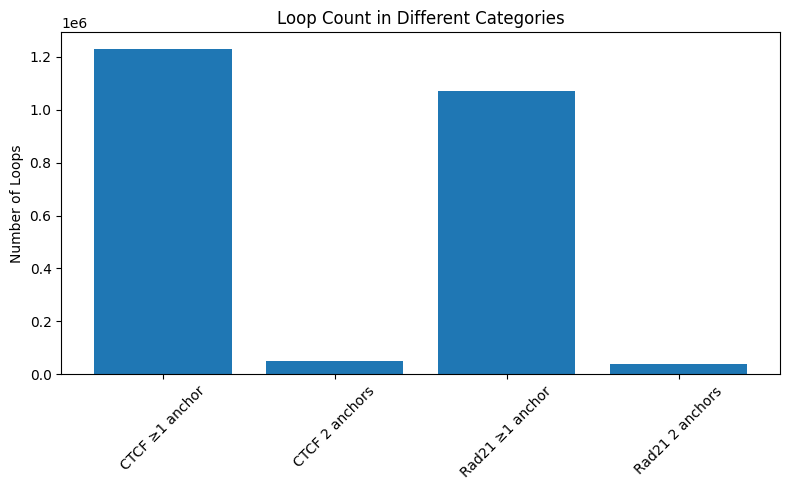

[INFO] Bar plot saved to: plot_basic.png


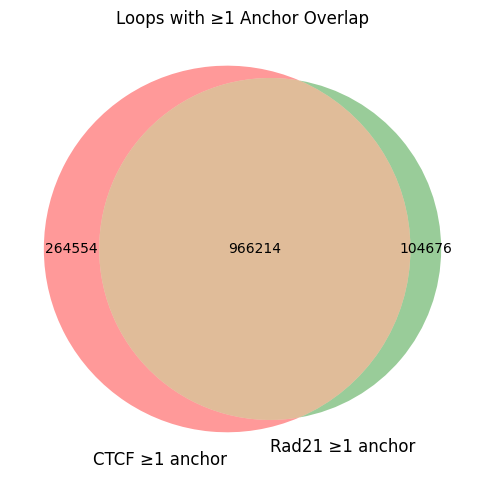

[INFO] Venn diagram saved to: plot_venn.png


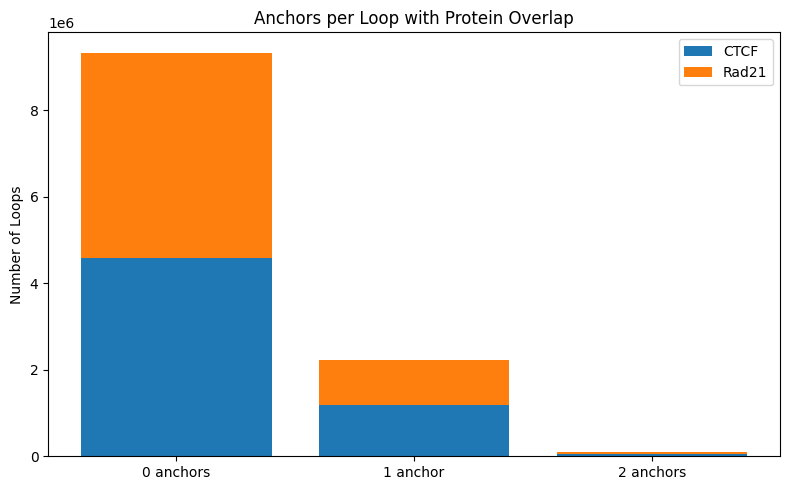

[INFO] Stacked bar chart saved to: plot_stacked.png


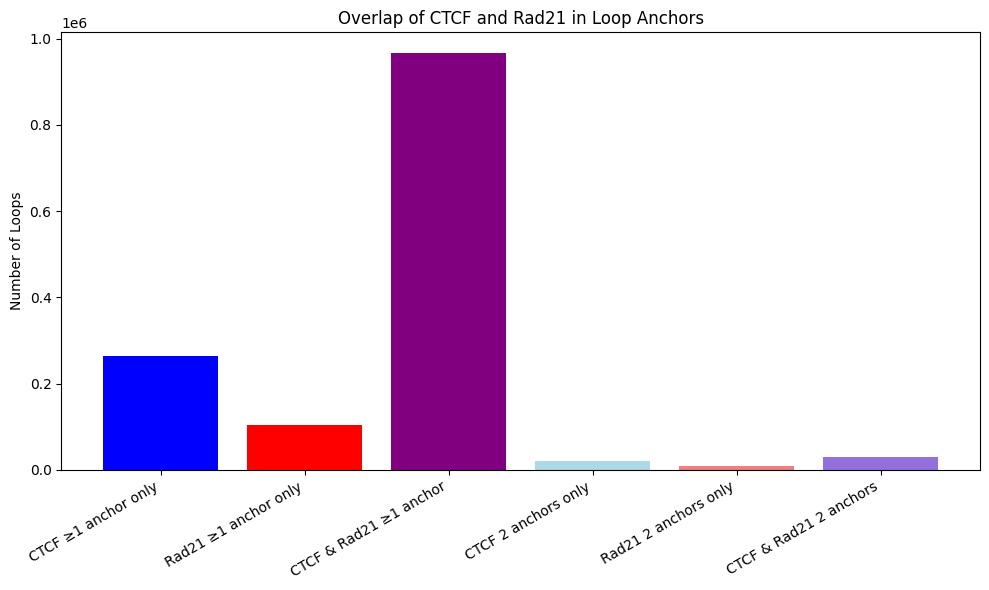

[INFO] Overlap comparison plot saved to: plot_overlap_summary.png


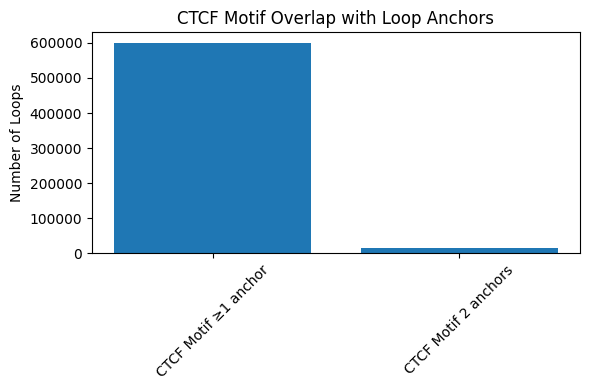

[INFO] CTCF motif bar plot saved to: ctcf_motif_counts.png
### [INFO] Analysis complete. ###


In [58]:
process_chia_pet(
    chia_file=chia_pet_path,
    ctcf_file=ctcf_path,
    rad21_file=rad21_path,
    ctcf_motif_path=ctcf_motif_path,
    start=0,
    stop=None,
    out_csv="chia_pet_annotated_small.csv",
    out_plot="loop_categories_barplot_small.png"
)


## 7. Analysis Results

After running the filtering and annotation pipeline on the ChIA-PET dataset (GM12878 cell line), the following summary statistics and visualizations were obtained.

---

### Summary Statistics (Console Output)

- **Total number of loops analyzed**: `5,815,083`
- **Loops with ≥1 anchor overlapping a CTCF peak**: `1,230,768`
- **Loops with both anchors overlapping CTCF peaks**: `49,905`
- **Loops with ≥1 anchor overlapping a Rad21 peak**: `1,070,890`
- **Loops with both anchors overlapping Rad21 peaks**: `37,902`
- **Loops with ≥1 anchor overlapping both CTCF and Rad21**: `966,214`
- **Loops with both anchors overlapping both CTCF and Rad21**: `29,179`
- **Loops with ≥1 anchor containing a CTCF motif**: `600,364`
- **Loops with both anchors containing CTCF motifs**: `15,340`

---

### Annotated CSV Output

The filtered results were saved to a file:
📄 `chia_pet_annotated_small.csv`

Each row in this file represents a ChIA-PET loop, and contains Boolean flags for overlap with each protein:

| Column Name              | Description                                          |
|--------------------------|------------------------------------------------------|
| `CTCF_1anchor`           | `True` if ≥1 anchor overlaps a CTCF ChIP-seq peak   |
| `CTCF_2anchors`          | `True` if both anchors overlap CTCF peaks           |
| `Rad21_1anchor`          | `True` if ≥1 anchor overlaps a Rad21 peak           |
| `Rad21_2anchors`         | `True` if both anchors overlap Rad21 peaks          |
| `CTCF_motif_1anchor`     | `True` if ≥1 anchor contains a CTCF motif (FIMO)    |
| `CTCF_motif_2anchors`    | `True` if both anchors contain CTCF motifs          |

---

### Visual Output Summary

Several plots were generated to illustrate the overlap categories and protein/motif distributions:

| Plot                         | Description                                                         |
|------------------------------|---------------------------------------------------------------------|
| `plot_basic.png`             | Basic bar chart: Loops with 1 or 2 anchors overlapping CTCF/Rad21  |
| `plot_venn.png`              | Venn diagram: Loops with ≥1 anchor overlap (CTCF vs Rad21)         |
| `plot_stacked.png`           | Stacked bars: Count of 0/1/2 anchors overlapping each protein       |
| `plot_overlap_summary.png`  | Comparison of shared/unique loops for CTCF and Rad21               |
| `ctcf_motif_counts.png`    | Extra credit: Motif counts in loop anchors                         |

Each figure provides a visual breakdown of regulatory patterns across loop anchors and supports integrative genomic interpretation.


In [6]:
# Optional: Preview output file
annotated_df = pd.read_csv("chia_pet_annotated_small.csv")
annotated_df.head()

,chrom1,start1,end1,chrom2,start2,end2,CTCF_1anchor,CTCF_2anchors,Rad21_1anchor,Rad21_2anchors
0,chr10,49043,49694,chr10,1596907,1597444,False,False,False,False
1,chr10,49291,49814,chr10,71061105,71061664,False,False,False,False
2,chr10,50096,50747,chr10,19437275,19437902,False,False,False,False
3,chr10,52377,52917,chr10,78536,79151,False,False,False,False
4,chr10,52428,53079,chr10,806777,807334,False,False,False,False


## Example Region Visualization (pyGenomeTracks)

Below is a snapshot of the genomic region showing:

- CTCF ChIP-seq peaks,
- Rad21 ChIP-seq peaks,
- ChIA-PET loops.

The visualization was generated using `pyGenomeTracks` and includes all relevant tracks defined in a configuration file (`tracks.ini`).


In [59]:
import pandas as pd

chia_pet_df = pd.read_csv("chia_pet_annotated_small.csv")

chia_pet_df["start_bin"] = (chia_pet_df["start1"] // 100000) * 100000
counts = chia_pet_df.groupby(["chrom1", "start_bin"]).size().reset_index(name="loop_count")

top_regions = counts.sort_values("loop_count", ascending=False).head()
print(top_regions)


      chrom1  start_bin  loop_count
5348   chr12   47700000        1087
10094  chr17   48000000        1024
1839    chr1  206600000        1018
2951   chr10   71300000        1016
24461   chr8   11400000        1005


In [60]:
import subprocess

top = top_regions.iloc[0]
chrom = top["chrom1"]
start = int(top["start_bin"])
end = start + 100000

region = f"{chrom}:{start}-{end}"

subprocess.run([
    "/home/kubog/.virtualenvs/GenomicsProject1/bin/pyGenomeTracks",
    "--tracks", "tracks.ini",
    "--region", region,
    "--outFileName", f"region_{chrom}_{start}-{end}.png"
])





INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [ctcf_peaks]
Value: 16.75926 in field 7 is not an integer
 Only the first 6 fields will be used.
100%|██████████| 20/20 [00:00<00:00, 54471.48it/s]
INFO:pygenometracks.tracksClass:initialize 4. [rad21_peaks]
Value: 157.93133 in field 7 is not an integer
 Only the first 6 fields will be used.
100%|██████████| 13/13 [00:00<00:00, 58756.41it/s]
INFO:pygenometracks.tracksClass:initialize 5. [chia_pet_loops]
100%|██████████| 287912/287912 [00:07<00:00, 37357.60it/s]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:10.550572633743286
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 10.106382978723405. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [ctcf_peaks]
DEBUG:p

CompletedProcess(args=['/home/kubog/.virtualenvs/GenomicsProject1/bin/pyGenomeTracks', '--tracks', 'tracks.ini', '--region', 'chr12:47700000-47800000', '--outFileName', 'region_chr12_47700000-47800000.png'], returncode=0)

### Example Region Visualization

Below is the region `{chrom}:{start}-{end}`, automatically selected as a loop-dense region:

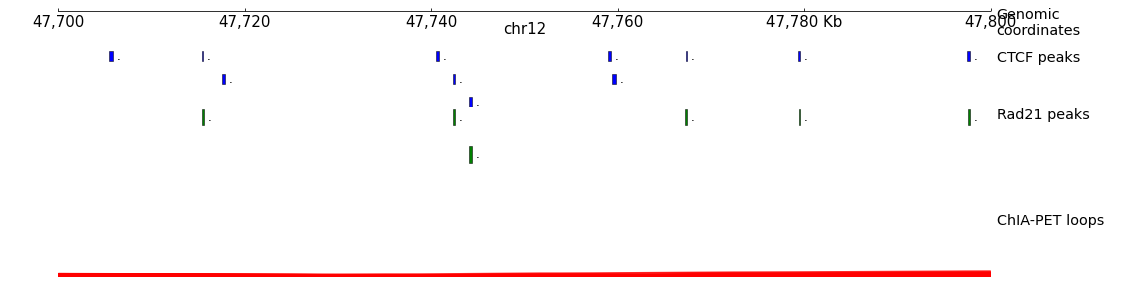

In [61]:
from IPython.display import Image

img_file = f"region_{chrom}_{start}-{end}.png"
Image(img_file)



## 8. Conclusions and Biological Interpretation

### Quantitative Insights:
- A large number of loops contain **at least one anchor** overlapping a **CTCF ChIP-seq peak** (1,230,768) or a **Rad21 peak** (1,070,890).
- Far fewer loops have **both anchors** overlapping peaks: ~49,905 for CTCF, ~37,902 for Rad21.
- A substantial subset of **966,214 loops** overlaps both CTCF and Rad21 in at least one anchor, indicating potential cooperative binding.
- A smaller group (**29,179 loops**) shows co-binding of **CTCF and Rad21 at both anchors**, potentially reflecting the most **functionally stable chromatin loops**.

---

### Extra Credit – CTCF Motif Analysis:
- **CTCF motif occurrence** was investigated using FIMO (from MEME Suite) by scanning the **hg38 reference genome** with the **MA0139.1 motif** from the **JASPAR database**.
- FIMO hits were converted to genomic intervals (BED format) and intersected with loop anchors.
- The analysis revealed:
  - **600,364 loops** have at least one anchor containing a CTCF motif.
  - Only **15,340 loops** have motifs present at **both anchors**.
- These results suggest that **not all CTCF peaks** are associated with **canonical motifs**, implying possible indirect binding or technical limitations of motif discovery.

---

### Biological Significance:
- **CTCF** is a key chromatin architectural protein involved in loop formation and insulation. It often binds to **specific DNA motifs**, enabling **loop anchoring and TAD formation**.
- **Rad21**, part of the **cohesin complex**, participates in **loop extrusion**, guiding long-range interactions in the genome.
- Loops with co-binding of CTCF and Rad21—especially those supported by CTCF motifs—likely represent **robust regulatory structures**.
- The relatively small number of loops with **both anchors** supported by **both ChIP-seq signal and motif presence** points to a subset of **high-confidence, structurally and functionally relevant chromatin loops**.

---

